In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
#Brining in tensorflow datasets for fashion mnist
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from pprint import pprint

In [3]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

# 2. Viz Data and Build Dataset

In [4]:
import numpy as np
import pandas as pd

In [5]:
# Set up connection aka iterator
data_iterator = ds.as_numpy_iterator()

2023-06-13 23:17:38.218856: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [6]:
# Getting data out of the pipelines
data_iterator.next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

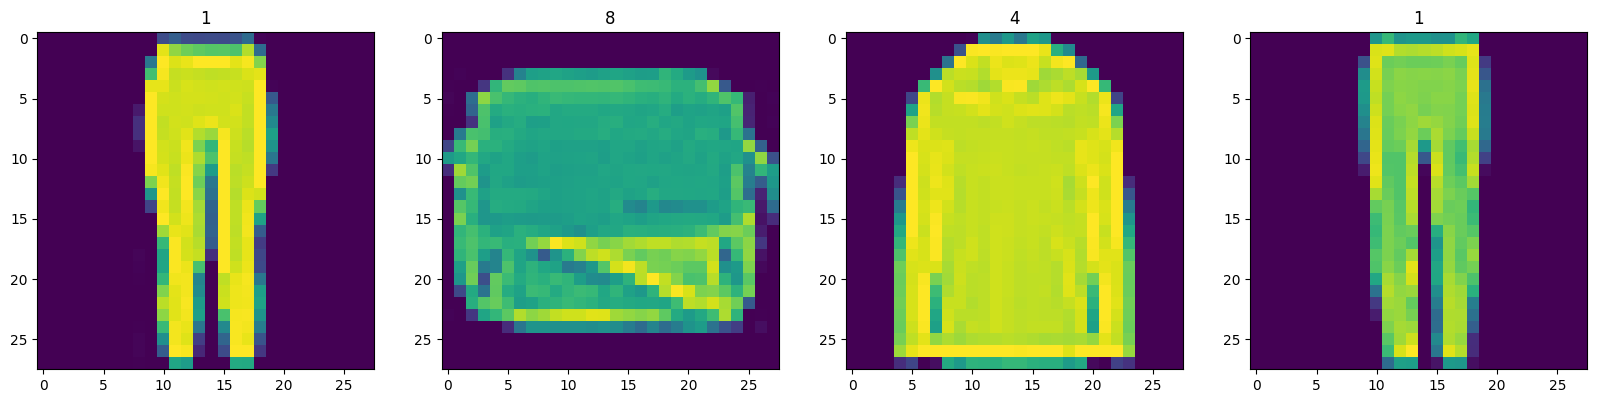

In [7]:
# Set up the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for i in range(4):
    sample = data_iterator.next()
    ax[i].imshow(np.squeeze(sample['image']))  
    ax[i].title.set_text(sample['label'])

In [8]:
# Scale and return images from 0 to 1
def scale_images(data):
    image = data['image']
    return image/255

In [9]:
# Reload the dataset
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
# Cache the dataset for that batch
ds = ds.cache()
# Shuffle it up
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

In [10]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Build Neural Network

## 3.1 Import Modelling Components

In [11]:
# Bring in the Swquential api for the generator and the discriminator
from tensorflow.keras.models import Sequential
# Bring in the Layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

## 3.2 Build Generator

In [12]:
def build_generator():
    model = Sequential()
    
    # Tajes ub random valuea and reshapes it to 7x7x128 
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim = 128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128,5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128,5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128,4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128,4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv Layer to get to one channel
    model.add(Conv2D(1,3, padding='same', activation='sigmoid'))
    
    return model

In [13]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 0s 82ms/step


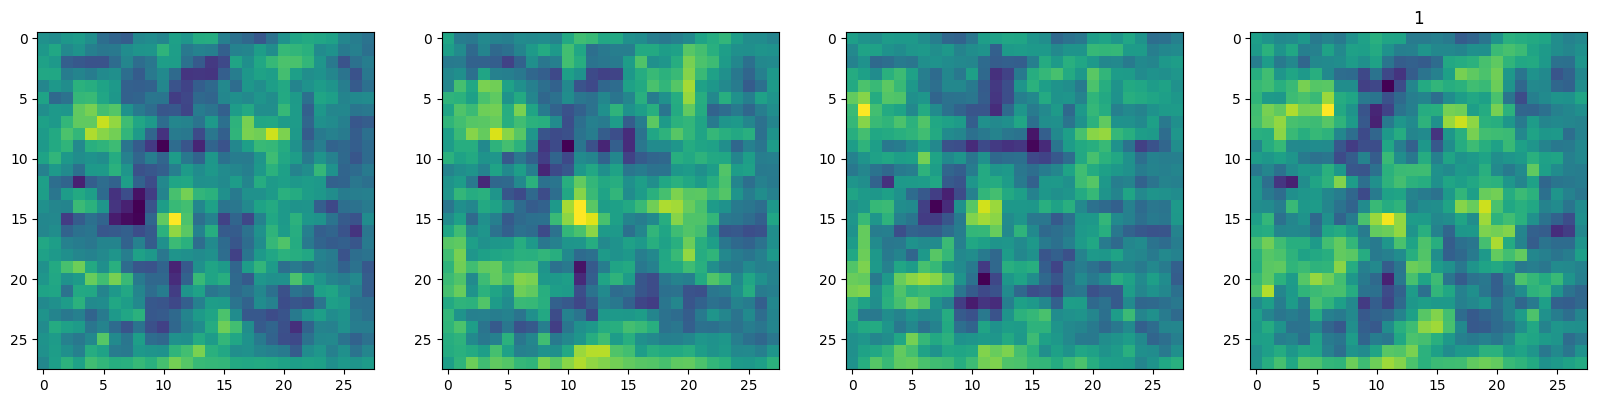

In [14]:
# Generate new fashion
img = generator.predict(np.random.rand(4,128,1))
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx, x in enumerate(img):
    ax[idx].imshow(np.squeeze(x))
    ax[i].title.set_text(sample['label'])

## 3.3 Build Discriminator

In [15]:
def build_discriminator():
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32,5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [16]:
discriminator = build_discriminator()

In [17]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [18]:
img.shape

(4, 28, 28, 1)

In [19]:
discriminator.predict(img)

1/1 [==============================] - 0s 37ms/step


array([[0.5021732 ],
       [0.5022175 ],
       [0.50221324],
       [0.5021979 ]], dtype=float32)

# 4. Construct Training Loop

## 4.1 Set up Losses and Optimizers

In [20]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary Cross Tropy is going to be the Loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [21]:
g_opt = Adam(learning_rate = 0.0001)
d_opt = Adam(learning_rate = 0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

## 4.2 Build subclassed Model

In [22]:
# Import the base model class to subclass our training step
from tensorflow.keras.models import Model

In [42]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        #create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator
        pass
    
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for Losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
        pass
    
    def train_step(self, batch):
        # Get the data   
        real_images = batch 
        fake_images = self.generator( tf.random.normal((128, 128,1)), training = False )
        
        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = - 0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learnb
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        
        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal( (128,128,1)), training = True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate Loss - trick to traning to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
                                        
        return {"d_loss":total_d_loss, "g_loss": total_g_loss}

In [43]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [44]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

## 4.3 Build Callack

In [45]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [46]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = araray_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

## 4.3 Train

In [47]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=20, callbacks = [ModelMonitor()])

Epoch 1/20
177/469 [==========>...................] - ETA: 37:51 - d_loss: 0.5636 - g_loss: 0.6996

KeyboardInterrupt: 

## 4.4 Review Performance